# SciBERT Evaluation

## Imports, Loading Model and Dataset

In [1]:
import pickle
import re
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm
from collections import defaultdict, Counter
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_auc_score
from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients, TokenReferenceBase, visualization

sns.set_theme()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
# Variables to tune
max_len = 100


# Loading of tokenizer and model
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', do_lower_case=True)

class SciBERTClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(SciBERTClassifier, self).__init__()

        self.SciBERT = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 3)

    def forward(self, input_ids, attention_mask):
        x = self.SciBERT(input_ids=input_ids, attention_mask=attention_mask)
        x = x[1]
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        #print(x.shape)
        return x

# model = torch.load("models/scicite_roberta.pt")
model = torch.load("../models/scibert.pt")
model.to(device)
model.eval()
model.zero_grad()


# Creating mapping from label name to index
label_2_idx = ['background', 'method', 'result']


# Reading data
train_df = pd.read_json(path_or_buf=r'../scicite/train.jsonl', lines=True)
test_df = pd.read_json(path_or_buf=r'../scicite/test.jsonl', lines=True)
val_df = pd.read_json(path_or_buf=r'../scicite/dev.jsonl', lines=True)

# train_df = train_df[['string', 'label']]
# test_df = test_df[['string', 'label']]
# val_df = val_df[['string', 'label']]

In [3]:
def parse_section_name(raw_section_name):
    if raw_section_name is None or not raw_section_name.strip():
        return "unknown"
    for i, c in enumerate(raw_section_name):
        if c.isalpha():
            break
    section_name = raw_section_name[i:]
    section_name = section_name.lower().strip()

    # Map to discrete categories
    sn_mappings = {"discussion": {"discussion", "evaluation", "general discussion", "discussion and conclusions", "technical considerations",
                                  "discussion, limitations and conclusion",
                                 },
                   "introduction": {"introduction", "related work", "related works"},
                   "method": {"methods", "experiments", "methodology", "implementation", "experimental setup", "experimental design",
                              "implementation details", "experiment", "numerical experiments", "setup", "experimental settings", "experimental setting",
                              "experiment setup",
                             },
                   "results": {"results", "results and discussion", "conclusions", "experimental results", "conclusion", "results & discussion",
                               "findings",
                              },
                   "background": {"background", "present address:"},
                   "material and methods": {"materials and methods"}
                  }
    for k, sns in sn_mappings.items():
        if section_name in sns:
            return k
    return "unknown"

train_df["sectionName"] = train_df["sectionName"].apply(parse_section_name)
test_df["sectionName"] = test_df["sectionName"].apply(parse_section_name)
val_df["sectionName"] = val_df["sectionName"].apply(parse_section_name)

# Either bin label confidence or use it as it is
train_df["label_confidence"] = (train_df["label_confidence"].round(1) - 0.6).multiply(10).apply(lambda x: "1" if pd.isnull(x) else str(int(x)))
test_df["label_confidence"] = (test_df["label_confidence"].round(1) - 0.6).multiply(10).apply(lambda x: "1" if pd.isnull(x) else str(int(x)))
val_df["label_confidence"] = (val_df["label_confidence"].round(1) - 0.6).multiply(10).apply(lambda x: "1" if pd.isnull(x) else str(int(x)))
# train_df["label_confidence"] = train_df["label_confidence"].fillna(0.87)  # Replace nans with mean of label confidence.

def get_label_confidence(lc_bin):
    mapper = ("very low", "low", "medium", "high", "very high")
    return mapper[int(lc_bin)]

train_df["label_confidence"] = train_df["label_confidence"].apply(get_label_confidence)
test_df["label_confidence"] = test_df["label_confidence"].apply(get_label_confidence)
val_df["label_confidence"] = val_df["label_confidence"].apply(get_label_confidence)

def get_proper_source(raw_source):
    mapper = {"explicit": "explicit",
              "properNoun": "proper noun",
              "acronym": "acronym",
              "acronymParen": "acronym paren",
              "andPhrase": "and phrase",
              "etAlPhrase": "et al phrase",
              None: "unknown",
              }
    return mapper[raw_source]

train_df["source"] = train_df["source"].apply(get_proper_source)
test_df["source"] = test_df["source"].apply(get_proper_source)
val_df["source"] = val_df["source"].apply(get_proper_source)

def get_full_prompt(row):
    source = row["source"]
    section_name = row["sectionName"]
    is_key_citation = "is" if row["isKeyCitation"] else "is not"
    label_confidence = row["label_confidence"]
    text = row["string"]
    prompt = f"This text is from the source '{source}'. It {is_key_citation} a key citation and is from the section '{section_name}'. This is the text: {text}"
    return prompt


train_df["prompt"] = train_df.apply(get_full_prompt, axis=1)
test_df["prompt"] = test_df.apply(get_full_prompt, axis=1)
val_df["prompt"] = val_df.apply(get_full_prompt, axis=1)

In [ ]:
X_test_encoded = tokenizer.batch_encode_plus(test_df["string"].tolist(),
                                             padding=True,
                                             truncation=True,
                                             max_length = max_len,
                                             return_tensors='pt')

y_test = torch.tensor(test_df["label"].apply(lambda row: label_2_idx.index(row)).tolist())

test_dataset = TensorDataset(X_test_encoded["input_ids"], X_test_encoded["attention_mask"], y_test)

batch_size = 5

test_dl = DataLoader(test_dataset, 
                     sampler=SequentialSampler(test_dataset),
                     batch_size=batch_size)

def evaluate(dataloader_test):
    model.eval()
    predictions, true_vals = [], []
    for batch in dataloader_test:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        
        inputs = {'input_ids':      input_ids,
                  'attention_mask': attention_mask,
                 }
        with torch.no_grad():
            logits = model(**inputs)
        logits = logits.detach().cpu().numpy()
        label_ids = batch[2]
        predictions.append(logits)
        true_vals.append(label_ids)
    predictions = np.concatenate(predictions,axis=0)
    probs = F.softmax(torch.tensor(predictions)).numpy()
    predictions = np.argmax(predictions, axis=1)
    true_vals = np.concatenate(true_vals, axis=0)
    return predictions, true_vals, probs

y_pred, y_test, probs = evaluate(test_dl)

test_df["pred"] = [label_2_idx[y] for y in y_pred]
test_df

## Analysis

In [6]:
print(roc_auc_score(test_df["label"], probs, multi_class='ovo'))
print(classification_report(test_df["label"], test_df["pred"]))

0.9584283979287171
              precision    recall  f1-score   support

  background       0.88      0.92      0.90       997
      method       0.91      0.83      0.87       605
      result       0.82      0.88      0.85       259

    accuracy                           0.88      1861
   macro avg       0.87      0.87      0.87      1861
weighted avg       0.88      0.88      0.88      1861



In [5]:
print(f1_score(test_df["label"], test_df["pred"], average="macro"))

0.871791290422582


### Confusion Matrix

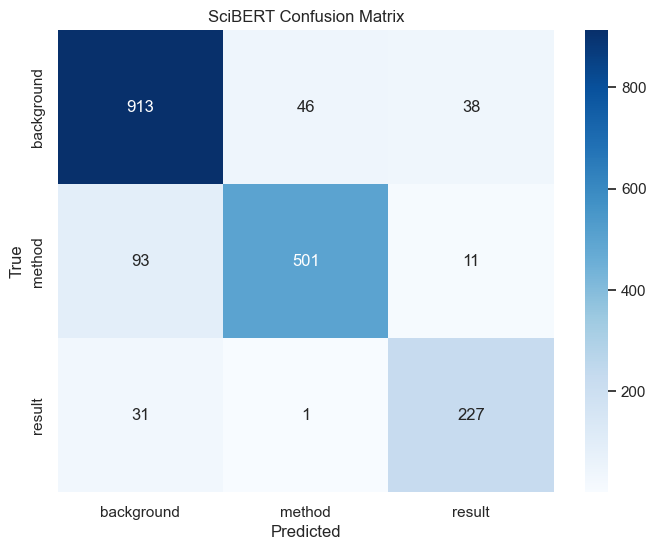

In [7]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_2_idx, yticklabels=label_2_idx)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SciBERT Confusion Matrix')
plt.show()

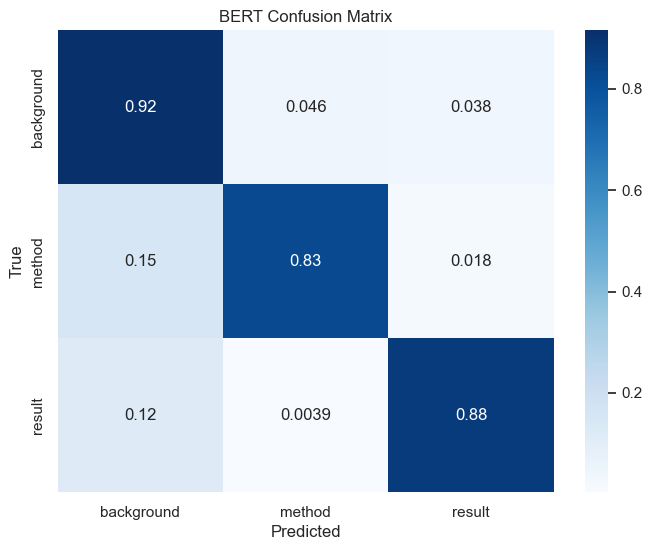

In [9]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_2_idx, yticklabels=label_2_idx)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT Confusion Matrix')
plt.show()

Actually most misclassification comes from method being misclassified as background.

### Error Analysis

In [59]:
x = test_df.loc[(test_df["label"] == "result") & (test_df["label"] != test_df["pred"])]
x.sectionName.value_counts()

discussion    24
results        5
unknown        3
Name: sectionName, dtype: int64

In [62]:
x[x["pred"] == "method"].sectionName.value_counts()

unknown    1
Name: sectionName, dtype: int64

In [61]:
x[x["pred"] == "background"].sectionName.value_counts()

discussion    24
results        5
unknown        2
Name: sectionName, dtype: int64

In [16]:
y = test_df.loc[(test_df["label"] == "background") & (test_df["pred"] == "background")]
y.sectionName.value_counts()

discussion              486
results                 214
unknown                 130
introduction             70
method                    8
background                4
material and methods      1
Name: sectionName, dtype: int64

In [15]:
y = test_df.loc[(test_df["label"] == "method") & (test_df["pred"] == "method")]
y.sectionName.value_counts()

method                  368
unknown                  67
results                  49
discussion               16
material and methods      1
Name: sectionName, dtype: int64

In [17]:
y = test_df.loc[(test_df["label"] == "result") & (test_df["pred"] == "result")]
y.sectionName.value_counts()

discussion      200
results          14
unknown          11
introduction      2
Name: sectionName, dtype: int64

Substantial number of misclassified methods have section name "method", this should highly suggest that it is a method since background and result have very very few method section names.

### Examples of each label

In [ ]:
for row in train_df[train_df["label"] == "background"]["string"][:5]:
    print(row)
    print()

In [ ]:
for row in train_df[train_df["label"] == "method"]["string"][:5]:
    print(row)
    print()

In [ ]:
for row in train_df[train_df["label"] == "result"]["string"][:5]:
    print(row)
    print()

## Get Attributions

### Calculate all attributions

In [5]:
def predict(inputs, mask):
    output = model(inputs, attention_mask=mask)  # model(input_ids, attention_mask=attention_mask)
    return F.softmax(output, dim=-1)


def predict2(inputs, mask):
    output = model(inputs, attention_mask=mask)
    return torch.sigmoid(output).max(1).indices


def interpret_sentence(model, sentence, vis_data_records_ig, max_len, token_reference, lig, label, label_2_idx, target="pred", device="cpu", debug=False):
    model.zero_grad()
    text = tokenizer.tokenize(sentence)

    # input_indices = torch.tensor([tokenizer.encode(sentence, padding="max_length", max_length=max_len)]).to(device)
    #input_indices = input_indices.unsqueeze(0)
    text_enc = tokenizer.encode_plus(sentence, padding="max_length", max_length=max_len)
    input_indices = torch.tensor([text_enc["input_ids"]]).to(device)
    mask = torch.tensor([text_enc["attention_mask"]]).to(device)

    # predict
    pred_probs = predict(input_indices, mask)
    pred_ind = predict2(input_indices, mask).item()
    pred = label_2_idx[pred_ind]

    # generate reference indices for each sample
    # reference_indices = token_reference.generate_reference(max_len, device=device).unsqueeze(0)
    reference_indices = input_indices.clone()
    reference_indices[(input_indices != 102) & (input_indices != 103)] = 1
    reference_indices.to(device)
    ref_mask = torch.zeros(reference_indices.size()).to(device)
    # compute attributions and approximation delta using layer integrated gradients
    label_idx = label_2_idx.index(label)
    if target == "pred":
        target = pred_ind
    else:
        target = label_idx
    attributions_ig, delta = lig.attribute((input_indices, mask), (reference_indices, ref_mask), target=target, n_steps=50, return_convergence_delta=True)
    if debug:
        print(text)
        print(f"Ref: {reference_indices}")
        print(f"Input indices: {input_indices}")
        print(attributions_ig.sum(dim=2).squeeze(0))
        print(f"last non-zero index: {attributions_ig.sum(dim=2).squeeze(0).nonzero().max()}, {(input_indices[0] == 2).nonzero(as_tuple=True)[0].item()}")
        print(pred_ind, pred)
        print(pred_probs)
        print('pred: ', pred_ind, '(', '%.2f'%pred_probs.max(1).values, ')', ', delta: ', abs(delta))

    text = ["".join(tokenizer.decode(idx).split()) for idx in input_indices[0]]

    add_attributions_to_visualizer(attributions_ig, text, pred_probs, pred, label, delta, vis_data_records_ig)


def add_attributions_to_visualizer(attributions, text, pred_probs, pred, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # Remove padding
    try:
        first_pad_idx = text.index(tokenizer.pad_token)
        text = text[:first_pad_idx]
        attributions = attributions[:first_pad_idx]
    except ValueError:
        pass
    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred_probs.max(1).values.item(),
                            pred,
                            label,
                            0,
                            attributions.sum(),
                            text,
                            delta))


def interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=0, target="pred", device="cpu", debug=False):
    vis_data_records_ig = []

    lig = LayerIntegratedGradients(predict, model.SciBERT.embeddings)
    
    token_reference = TokenReferenceBase(reference_token_idx=pad_idx)

    for idx, row in df.iterrows():
        torch.cuda.empty_cache()
        sentence = row["string"]
        label = row["label"]
        interpret_sentence(model, sentence, vis_data_records_ig, max_len, token_reference, lig, label, label_2_idx, target=target, device=device, debug=debug)
    return vis_data_records_ig

In [ ]:
# all_attributions = list()
# torch.cuda.empty_cache()
# vis_data_records_ig = interpret_batch(test_df, model, predict, max_len, label_2_idx, pad_idx=1, target="pred", device=device, debug=False)
# all_attributions = [{"input_ids": record.raw_input_ids, 
#                      "attributions": record.word_attributions, 
#                      "label": record.true_class, 
#                      "pred": record.pred_class, 
#                     } for record in vis_data_records_ig]

In [6]:
# Save attributions to prevent the need for running calculations again
# with open("attributions.pkl", "wb") as f:
#     pickle.dump(all_attributions, f)
with open("../attributions/attributions_scibert.pkl", "rb") as f:
    all_attributions = pickle.load(f)
for attribution in all_attributions:
    attribution["input_ids"] = ["".join(tok.split()) for tok in attribution["input_ids"]]

### Analyze Attributions

In [12]:
def get_ngram_attributions(records, pred, n=1):
    ngram_attrs = defaultdict(lambda: [[]])
    for record in records:
        if record["pred"] == pred:
            tokens = record["input_ids"]
            attributions = record["attributions"]
            for i in range(len(tokens) + n - 1):
                ngram = tuple(tokens[i:i+n])
                ngram_attr = attributions[i:i+n].sum() / n
                ngram_attrs[ngram][0].append(ngram_attr)
    return ngram_attrs


def get_ngram_attribution_df(ngram_attributions):
    ngram_attributions_df = pd.DataFrame.from_dict(ngram_attributions, orient="index").reset_index().rename(columns={"index": "ngram", 0: "attribution"})

    ngram_attributions_df.attribution = ngram_attributions_df.attribution.apply(lambda x: np.array(x))
    ngram_attributions_df["mean"] = ngram_attributions_df.attribution.apply(lambda x: x.mean())
    ngram_attributions_df["median"] = ngram_attributions_df.attribution.apply(lambda x: np.median(x))
    ngram_attributions_df["std"] = ngram_attributions_df.attribution.apply(lambda x: x.std())
    ngram_attributions_df["count"] = ngram_attributions_df.attribution.apply(lambda x: len(x))
    
    ngram_attributions_df.sort_values("mean", ascending=False, inplace=True)
    
    return ngram_attributions_df

In [72]:
label = "background"  # background, method, result
target = "pred"

print(f"Correctly classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] == label)].iloc[:5]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

print(f"Incorrectly classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] != label)].iloc[:5]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

Correctly classified texts with reference to pred:


Incorrectly classified texts with reference to pred:


In [62]:
label = "background"  # background, method, result
target = "label"

print(f"Correctly classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] == label)].iloc[:5]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

print(f"Incorrectly classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] != label)].iloc[:5]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

Correctly classified texts with reference to label:


Incorrectly classified texts with reference to label:


In [63]:
label = "background"  # background, method, result
pred = "method"
target = "pred"

print(f"Classified texts with reference to {target}:")
torch.cuda.empty_cache()
df = test_df[(test_df["label"] == label) & (test_df["pred"] == pred)].iloc[:10]
vis_data_records_ig = interpret_batch(df, model, predict, max_len, label_2_idx, pad_idx=1, target=target, device=device, debug=False)

_ = visualization.visualize_text(vis_data_records_ig)

Classified texts with reference to pred:


### Get distribution of attribution scores

Background mean: 0.03, median: 0.00, max: 0.96, min: -0.91, std: 0.09
Method mean: 0.03, median: 0.00, max: 0.90, min: -0.93, std: 0.09
Result mean: 0.02, median: 0.00, max: 0.91, min: -0.89, std: 0.10


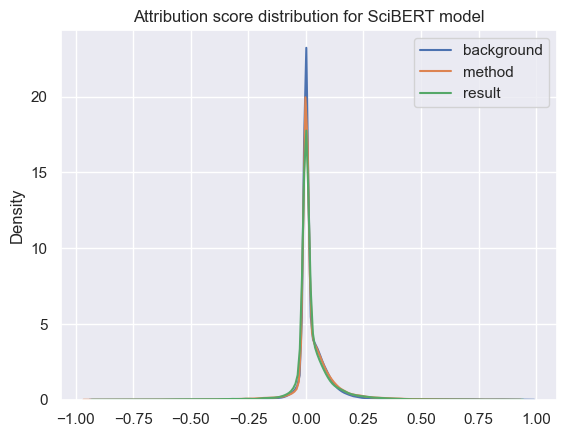

In [9]:
background_attributions = [a for record in all_attributions for a in record["attributions"] if record["pred"] == "background"]
method_attributions = [a for record in all_attributions for a in record["attributions"] if record["pred"] == "method"]
result_attributions = [a for record in all_attributions for a in record["attributions"] if record["pred"] == "result"]
plt.title("Attribution score distribution for SciBERT model")
sns.kdeplot(background_attributions, label="background")
sns.kdeplot(method_attributions, label="method")
sns.kdeplot(result_attributions, label="result")
plt.legend()
print(f"Background mean: {np.mean(background_attributions):.2f}, median: {np.median(background_attributions):.2f}, max: {np.max(background_attributions):.2f}, min: {np.min(background_attributions):.2f}, std: {np.std(background_attributions):.2f}")
print(f"Method mean: {np.mean(method_attributions):.2f}, median: {np.median(method_attributions):.2f}, max: {np.max(method_attributions):.2f}, min: {np.min(method_attributions):.2f}, std: {np.std(method_attributions):.2f}")
print(f"Result mean: {np.mean(result_attributions):.2f}, median: {np.median(result_attributions):.2f}, max: {np.max(result_attributions):.2f}, min: {np.min(result_attributions):.2f}, std: {np.std(result_attributions):.2f}")

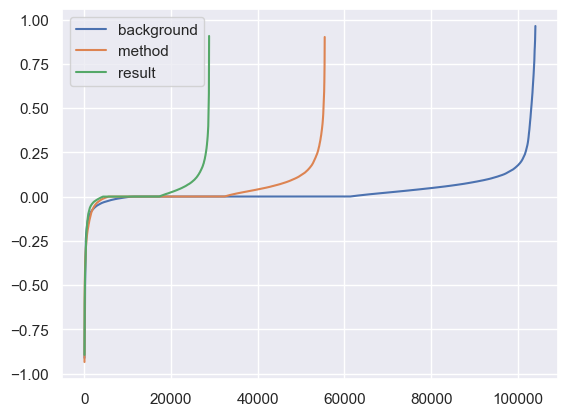

In [23]:
background_attributions.sort()
method_attributions.sort()
result_attributions.sort()
sns.lineplot(background_attributions, label="background")
sns.lineplot(method_attributions, label="method")
sns.lineplot(result_attributions, label="result")
plt.legend()

### Get top n tokens for each label

In [13]:
n = 30

top_n_tokens = dict()

for pred in ("background", "method", "result"):
    records = [record for record in all_attributions if record["pred"] == pred]
    ngram_attributions_1 = get_ngram_attributions(records, pred, n=1)
    df = get_ngram_attribution_df(ngram_attributions_1)
    toks = df[(df["count"] > 4) & (df["std"] < 0.1)].sort_values("mean", ascending=False)[:n]["ngram"].apply(lambda x: x[0]).values.tolist()
    top_n_tokens[pred] = set(toks)

bot_n_tokens = dict()

for pred in ("background", "method", "result"):
    records = [record for record in all_attributions if record["pred"] == pred]
    ngram_attributions_1 = get_ngram_attributions(records, pred, n=1)
    df = get_ngram_attribution_df(ngram_attributions_1)
    toks = df[(df["count"] > 4) & (df["std"] < 0.1)].sort_values("mean", ascending=True)[:n]["ngram"].apply(lambda x: x[0]).values.tolist()
    bot_n_tokens[pred] = set(toks)

#### Find the proportion of top n tokens in sentences

In [37]:
def get_proportions_top_n(n_tokens, correct_pred=True, reference="pred"):
    correct = "correctly" if correct_pred else "wrongly"
    ref = f" from {reference} class" if not correct_pred else ""
    print(f"Proportion of {correct} labelled records with n tokens{ref} in them.")
    for pred in ("background", "method", "result"):
        tot_correct_pred = 0
        tot_correct_w_top_n_pred = 0
        for record in all_attributions:
            if record["pred"] == pred and (record["pred"] == record["label"] if correct_pred else record["pred"] != record["label"]):
                tot_correct_pred += 1
                for tok in record["input_ids"]:
                    if tok in n_tokens[pred if reference == "pred" else record["label"]]:
                        tot_correct_w_top_n_pred += 1
                        break
        print(pred, tot_correct_w_top_n_pred, tot_correct_pred, tot_correct_w_top_n_pred / tot_correct_pred)

In [38]:
get_proportions_top_n(top_n_tokens, correct_pred=True, reference="pred")
print()
get_proportions_top_n(top_n_tokens, correct_pred=False, reference="pred")
print()
get_proportions_top_n(top_n_tokens, correct_pred=False, reference="label")

Proportion of correctly labelled records with n tokens in them.
background 495 912 0.5427631578947368
method 212 502 0.42231075697211157
result 182 230 0.7913043478260869

Proportion of wrongly labelled records with n tokens from pred class in them.
background 58 120 0.48333333333333334
method 13 47 0.2765957446808511
result 33 50 0.66

Proportion of wrongly labelled records with n tokens from label class in them.
background 39 120 0.325
method 14 47 0.2978723404255319
result 28 50 0.56


In [45]:
get_proportions_top_n(bot_n_tokens, correct_pred=True, reference="pred")
print()
get_proportions_top_n(bot_n_tokens, correct_pred=False, reference="pred")
print()
get_proportions_top_n(bot_n_tokens, correct_pred=False, reference="label")

Proportion of correctly labelled records with n tokens in them.
background 203 912 0.2225877192982456
method 480 502 0.9561752988047809
result 176 230 0.7652173913043478

Proportion of wrongly labelled records with n tokens from pred class in them.
background 56 120 0.4666666666666667
method 47 47 1.0
result 39 50 0.78

Proportion of wrongly labelled records with n tokens from label class in them.
background 113 120 0.9416666666666667
method 19 47 0.40425531914893614
result 23 50 0.46


### Get high attribution N-grams

In [ ]:
pred = "background"
n = 3

records = [record for record in all_attributions if record["pred"] == pred]
ngram_attributions = get_ngram_attributions(records, pred, n=n)
df = get_ngram_attribution_df(ngram_attributions)
df = df[(df["count"] > 4) & (df["std"] < 0.1)].sort_values("mean", ascending=False)

display(df[:20])
display(df[-20:])

In [ ]:
pred = "method"
n = 3

records = [record for record in all_attributions if record["pred"] == pred]
ngram_attributions = get_ngram_attributions(records, pred, n=n)
df = get_ngram_attribution_df(ngram_attributions)
df = df[(df["count"] > 1) & (df["std"] < 0.1)].sort_values("mean", ascending=False)

display(df[:20])
display(df[-20:])

In [ ]:
pred = "result"
n = 3

records = [record for record in all_attributions if record["pred"] == pred]
ngram_attributions = get_ngram_attributions(records, pred, n=n)
df = get_ngram_attribution_df(ngram_attributions)
df = df[(df["count"] > 1) & (df["std"] < 0.1)].sort_values("mean", ascending=False)

display(df[:20])
display(df[-20:])

#### Why are the ngrams for background so shit?
Check if there are alot more [0] kind of tokens in background texts.

In [106]:
df = test_df.copy()
df["ref_count"] = df["string"].apply(lambda s: len(re.findall("\[[^\]]*\]", s)))
for pred in ("background", "method", "result"):
    x = df[(df["pred"] == pred) & (df["label"] == pred)]["ref_count"]
    print(pred, x.mean(), x.median(), x.max(), x.min())

background 0.5217903415783275 0.0 16 0
method 0.6471774193548387 0.0 7 0
result 0.6 0.0 10 0


In [107]:
df = test_df.copy()
df["ref_count"] = df["string"].apply(lambda s: len(re.findall("et[^(et)]*al", s)))
for pred in ("background", "method", "result"):
    x = df[(df["pred"] == pred) & (df["label"] == pred)]["ref_count"]
    print(pred, x.mean(), x.median(), x.max(), x.min())

background 0.8845700824499411 0.0 15 0
method 0.5443548387096774 0.0 7 0
result 1.0085106382978724 0.0 15 0


### Get high attribution phrases by threshold

In [55]:
high_attr_ngrams = {"background": [], "method": [], "result": []}
thr = 0.2
for record in all_attributions:
    pred = record["pred"]
    tokens = record["input_ids"]
    attributions = record["attributions"]
    subtok = list()
    subattr = list()
    for i in range(len(tokens)):
        if sum(subattr) + attributions[i] > thr * (len(subtok) + 1):  # averaged threshold
        # if attributions[i] > thr:  # hard threshold
            subtok.append(tokens[i])
            subattr.append(attributions[i])
        elif subtok:
            high_attr_ngrams[pred].append([subtok, subattr])
            subtok = list()
            subattr = list()

In [ ]:
ngram_attrs = high_attr_ngrams["method"]
Counter(" ".join(pair[0]) for pair in ngram_attrs)